## Prep

In [1]:
# Import packages
import pandas as pd
import plotly.graph_objects as go
import networkx as nx
from ds_common_utils.aux.io.snowflake_tools import SnowflakeTools
from math import log
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt
import community.community_louvain as community_louvain
import numpy as np

In [2]:
# Get connection
con = SnowflakeTools().get_snowflake_ctx(
     method = 'token',
    user = '250807',
    role = 'INSIGHT_ANALYST_MERCH_DE_GENERAL_PRD',
    warehouse = 'INSIGHT_ANALYST_WH'
)
with open('sql/item_association.sql', 'r') as query:
        df = pd.read_sql_query(query.read(), con)

snowflake_tools - 2025-06-24 18:20:43.976391+10:00 - Generating new token with 'INSIGHT_ANALYST_MERCH_DE_GENERAL_PRD' role and 'SESSION:ROLE-ANY' scope...
snowflake_tools - 2025-06-24 18:20:50.943528+10:00 - Saved token with '2025-06-24 22:20:50+10:00' expiry...


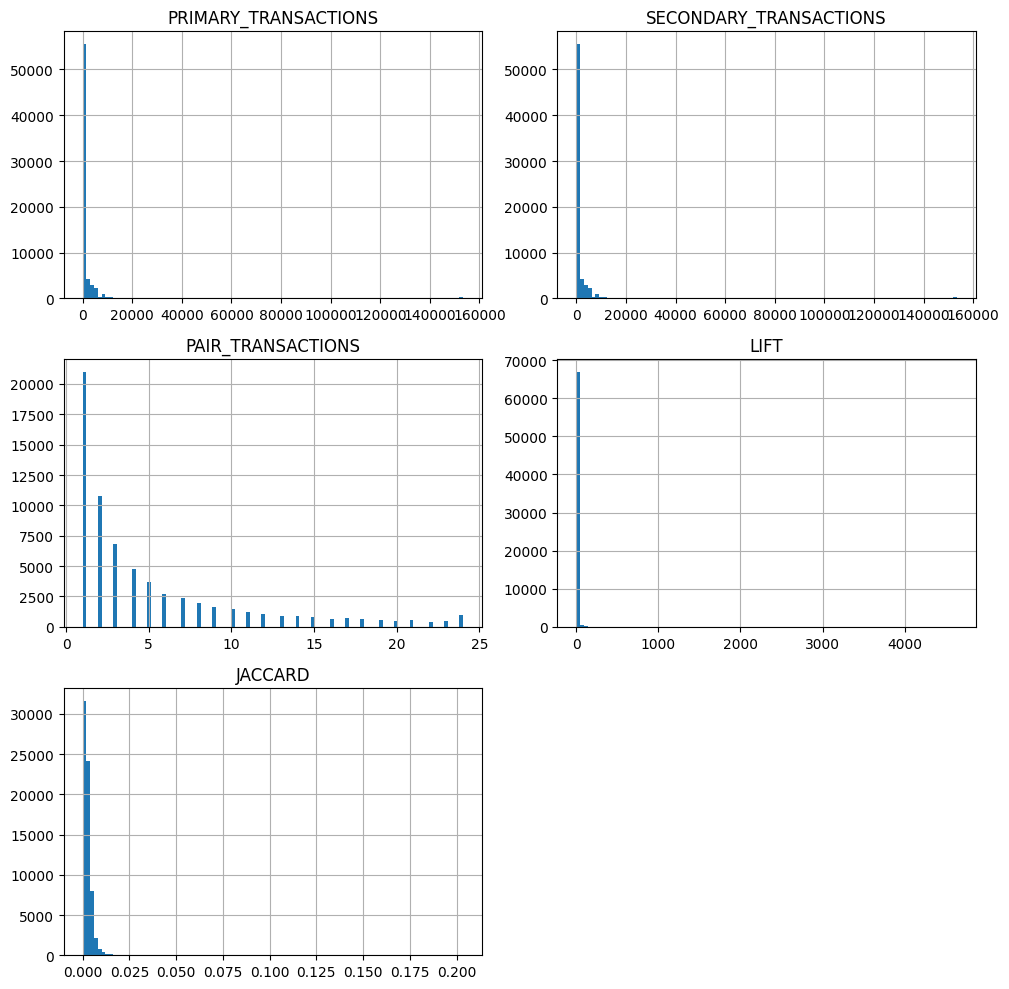

In [3]:
# Plot histograms of numerical columns
numeric_cols = df.select_dtypes(include='number').columns
df[numeric_cols].hist(bins=100, figsize=(10, 10), layout=(3, 2))
plt.tight_layout()
plt.show()

## Parameter Tuning

In [53]:
TRX_THRESHOLD = 10 # Min N frequent pairs
QUANTILE = 0.9 # Nth percentile of metric similarity
TOP_N = 2 # top-N associated item classes per primary class
RESO = 1.5 # >1.0 → more, smaller communities
METRIC = 'LIFT' # LIFT or JACCARD

## Working

In [54]:
filtered_df = df[(df['PRIMARY_ID'] != '400 RODENT PEST CONTROL' ) & ( df['SECONDARY_ID']!='400 RODENT PEST CONTROL')]

filtered_df = filtered_df[filtered_df['PAIR_TRANSACTIONS'] >= TRX_THRESHOLD]
threshold = filtered_df[METRIC].quantile(QUANTILE)
filtered_df = filtered_df[filtered_df[METRIC] >= threshold]
top_edges = filtered_df.sort_values(METRIC, ascending=False).groupby('PRIMARY_ID').head(TOP_N)


In [55]:
filtered_df.sort_values(by='PAIR_TRANSACTIONS', ascending=False)

,PRIMARY_ID,SECONDARY_ID,PRIMARY_TRANSACTIONS,SECONDARY_TRANSACTIONS,TRX_START_MONTH,TRX_END_MONTH,PAIR_TRANSACTIONS,LIFT,JACCARD
63544,402 PADLOCKS AND CABLES,401 GATE HARDWARE,954,1116,2024-06-01,2025-05-01,24,3.459300,0.011730
31620,400 PVC PIPE AND FITTINGS,400 PIPE AND FITTINGS,503,1318,2024-06-01,2025-05-01,24,5.555426,0.013356
28955,400 PIPE AND FITTINGS,400 PVC PIPE AND FITTINGS,1318,438,2024-06-01,2025-05-01,24,6.379862,0.013857
48959,401 GATE HARDWARE,402 PADLOCKS AND CABLES,1116,954,2024-06-01,2025-05-01,24,3.459300,0.011730
18606,400 HOUSE PLANT,400 INDOOR DECORATIVE,1654,780,2024-06-01,2025-05-01,24,2.854767,0.009959
19060,400 INDOOR DECORATIVE,400 HOUSE PLANT,787,1654,2024-06-01,2025-05-01,24,2.829375,0.009930
21014,400 LANDSCAPING TIMBER,400 FENCING TIMBER,320,526,2024-06-01,2025-05-01,23,20.969190,0.027947
27849,400 PERENNIAL FLOWERING,400 TREE AND SHRUB,1205,1006,2024-06-01,2025-05-01,23,2.898361,0.010512
25957,400 PAINT APPLICATORS,400 FENCE AND TIMBER PAINT,4471,172,2024-06-01,2025-05-01,23,4.589700,0.004978
24798,400 OPE MAINTENANCE,400 HANDHELD OPE ACC,592,1840,2024-06-01,2025-05-01,23,3.240245,0.009548


In [56]:
mode='lines',
line_shape='spline'
    
# Build node size map from your DataFrame
node_size_map = dict(zip(top_edges['PRIMARY_ID'], top_edges['PRIMARY_TRANSACTIONS']))

# Convert values to NumPy array
sizes = np.array(list(node_size_map.values()))

# Use np.ptp instead of .ptp()
norm_sizes = (sizes - sizes.min()) / np.ptp(sizes)  # scale to 0–1
scaled_sizes = 10 + norm_sizes * 30                 # scale to 10–40

# Final size map: Product ID → Scaled Size
scaled_size_map = dict(zip(node_size_map.keys(), scaled_sizes))

# Step 1: Build the full graph
G = nx.Graph()
for _, row in top_edges.iterrows():
    G.add_edge(row['PRIMARY_ID'], row['SECONDARY_ID'], weight=row[METRIC])

# Step 2: Louvain community detection
partition = community_louvain.best_partition(G, weight=METRIC, resolution=RESO)

# Step 3: Layout
pos = nx.spring_layout(G, weight='weight', seed=42
                      )

# Step 4: Edge trace (no filter on weight)
edge_x, edge_y = [], []
for u, v in G.edges():
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=1, color='gray'),
    hoverinfo='none',
    mode='lines'
)

# Step 5: Node trace with Louvain cluster coloring
color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']  # Extend if you expect >10 clusters

node_x, node_y, node_color, node_size, hover_text = [], [], [], [], []

for node in G.nodes():
    x, y = pos[node]
    cluster = partition[node]
    size = scaled_size_map.get(node, 10)  # default to small if missing

    node_x.append(x)
    node_y.append(y)
    node_color.append(color_list[cluster % len(color_list)])
    node_size.append(size)
    hover_text.append(f"Product ID: {node}<br>Cluster: {cluster}<br>Transactions: {int(size)}")

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',
    hoverinfo='text',
    text=[str(node) for node in G.nodes()],
    textposition='top center',
    marker=dict(
        color=node_color,
        size=node_size,  # <--- size now dynamic!
        line=dict(width=2, color='black')
    ),
    textfont=dict(
    size=16,          # increase for visibility
    color='black',
    family='Arial'
)
)
# Step 6: Plot
fig = go.Figure(
    data=[edge_trace, node_trace],
    layout=go.Layout(
        width=1200,          # increase width
    height=800, 
        title=dict(text='Louvain Product Clustering (All Edges)', x=0.5, font=dict(size=16)),
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20, l=20, r=20, t=40),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
    )
)

## Results

In [57]:
fig.show()

In [58]:
# Merge community partition info with filtered edges
partition_df = pd.DataFrame.from_dict(partition, orient='index', columns=['segment']).reset_index()
partition_df.rename(columns={'index': 'PRIMARY_ID'}, inplace=True)

# Merge and deduplicate
labelled_df = filtered_df.merge(partition_df, on='PRIMARY_ID', how='left')
labelled_df = labelled_df[['PRIMARY_ID', 'SECONDARY_ID', 'PRIMARY_TRANSACTIONS', 'SECONDARY_TRANSACTIONS', 'PAIR_TRANSACTIONS', METRIC, 'segment']].drop_duplicates()
labelled_df = labelled_df.sort_values(by=['segment', METRIC]).reset_index(drop=True)

# Expand display limits
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
display(labelled_df)

,PRIMARY_ID,SECONDARY_ID,PRIMARY_TRANSACTIONS,SECONDARY_TRANSACTIONS,PAIR_TRANSACTIONS,LIFT,segment
0,400 NZ COLD FOOD SWEET,400 NZ HOT DRINKS,31,40,12,1108.954839,0
1,400 NZ HOT DRINKS,400 NZ COLD FOOD SWEET,47,25,12,1371.666383,0
2,400 PAINT TAPES,401 AIR MOVEMENT,2411,450,20,2.828849,1
3,400 PAINT TAPES,400 INTERIOR PAINT,2411,458,21,2.918409,1
4,400 PAINT TAPES,401 POOL AND SPA,2411,216,10,2.946718,1
5,400 SYNTHETIC TURF,401 PLANT SUPPORT,190,3421,13,3.023947,1
6,401 FLOORING ADHESIVE,400 PAINT APPLICATORS,148,4471,14,3.219580,1
7,400 BUILDING WRAP,400 SCREWS,157,3151,11,3.260196,1
8,401 PLANT SUPPORT,400 SYNTHETIC TURF,3421,177,13,3.294629,1
9,400 BUILDERS FILM AND ACCESS,401 PLANT SUPPORT,131,3421,10,3.326803,1


In [59]:
# Sum of PRIMARY_TRANSACTIONS by PRIMARY_ID and segment
grouped = labelled_df.groupby(['segment', 'PRIMARY_ID'])['PRIMARY_TRANSACTIONS'].sum().reset_index()

# Sum total per segment
segment_totals = grouped.groupby('segment')['PRIMARY_TRANSACTIONS'].sum().reset_index(name='segment_total')

# Merge back to get both individual and segment totals
merged = grouped.merge(segment_totals, on='segment')
merged

,segment,PRIMARY_ID,PRIMARY_TRANSACTIONS,segment_total
0,0,400 NZ COLD FOOD SWEET,31,78
1,0,400 NZ HOT DRINKS,47,78
2,1,400 BUILDERS FILM AND ACCESS,262,35470
3,1,400 BUILDING WRAP,314,35470
4,1,400 GROUT AND SEALER,322,35470
5,1,400 PAINT TAPES,19288,35470
6,1,400 SYNTHETIC TURF,190,35470
7,1,401 FLOORING ADHESIVE,740,35470
8,1,401 PLANT SUPPORT,13684,35470
9,1,401 SHADE CLOTH AND SAILS,183,35470


Customers buying rodent pest control also commonly buy…
- Food & garden attractants → Prevention
- Renovation tools & materials → Discovery during works
- Outdoor timber or irrigation gear → Nesting hotspots
- Buckets, pipes, insulation → Utility zones needing sealing or inspection